In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
test_dir = '/content/images_final/test'

train_dir = '/content/images_final/train'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
!unzip "/content/drive/MyDrive/images_final.zip"

In [ ]:
def prepare_df(data_type):
    X = []
    y = []
    path = 'images_final/' + data_type + '/'

    for i in os.listdir(path):
      # print(i)
      # Image
      X.append(i)
      # Label
      y.append((i.split('_')[1]).split('.')[0])

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame()
    df['filename'] = X
    df['label'] = y

    return df



In [ ]:
df_train = prepare_df('train')
df_test = prepare_df('test')

In [ ]:
df_train.head()

,filename,label
0,331_Mazda.jpg,Mazda
1,138_Mazda.jpg,Mazda
2,217_Citroen.jpg,Citroen
3,180_VW.jpg,VW
4,217_VW.jpg,VW


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=[0.8,1.0],
    # channel_shift_range=30,
    # horizontal_flip=True,
)




# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory='images_final/train/',
    x_col='filename',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
df_test,
directory="images_final/test/",
x_col="filename",
y_col="label",
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=False,
class_mode='categorical',
target_size=(224,224))

Found 2879 validated image filenames belonging to 6 classes.
Found 511 validated image filenames belonging to 6 classes.


In [ ]:
x,y = next(train_generator)
x.shape

(32, 224, 224, 3)

In [ ]:
import matplotlib.pyplot as plt
def plot_images(img):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.axis('off')

In [ ]:
plot_images(x)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)
base_model.trainable = True
model = tf.keras.Sequential([
        data_augmentation,
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

# model = tf.keras.Sequential([
#         data_augmentation,
#         base_model,          
#         tf.keras.layers.GlobalAveragePooling2D(),
#         # tf.keras.layers.Dropout(0.5),
#         # tf.keras.layers.Dense(1024, activation='relu'),
#         # tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(6, activation='softmax')
#     ])

opt = tf.keras.optimizers.Adam(0.0001)
# Compile it
model.compile(optimizer=opt,
             loss='CategoricalCrossentropy',
             metrics=['categorical_accuracy'])

# Print The Summary of The Model
model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 5, 5, 2048)       14336     
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                       

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=5,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = test_generator.n//test_generator.batch_size
# fit model
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=test_generator,
          validation_steps=STEP_SIZE_VAL,
          epochs=10,
          callbacks=[early])

Epoch 1/10
14/89 [===>..........................] - ETA: 59s - loss: 1.8154 - categorical_accuracy: 0.1808 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


89/89 [==============================] - 113s 1s/step - loss: 1.6409 - categorical_accuracy: 0.3087 - val_loss: 1.4574 - val_categorical_accuracy: 0.3979
Epoch 2/10
89/89 [==============================] - 85s 955ms/step - loss: 1.1495 - categorical_accuracy: 0.5588 - val_loss: 1.0173 - val_categorical_accuracy: 0.6271
Epoch 3/10
89/89 [==============================] - 88s 993ms/step - loss: 0.7891 - categorical_accuracy: 0.7071 - val_loss: 0.9709 - val_categorical_accuracy: 0.6583
Epoch 4/10
89/89 [==============================] - 85s 956ms/step - loss: 0.5750 - categorical_accuracy: 0.7900 - val_loss: 0.8598 - val_categorical_accuracy: 0.7292
Epoch 5/10
89/89 [==============================] - 88s 985ms/step - loss: 0.4485 - categorical_accuracy: 0.8384 - val_loss: 0.7703 - val_categorical_accuracy: 0.7500
Epoch 6/10
89/89 [==============================] - 85s 960ms/step - loss: 0.3662 - categorical_accuracy: 0.8830 - val_loss: 0.4593 - val_categorical_accuracy: 0.8542
Epoch 7/10


In [ ]:
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

16/16 [==============================] - 13s 789ms/step - loss: 0.4856 - categorical_accuracy: 0.8434
[0.48562920093536377, 0.8434442281723022]
Accuracy: 84.3444%
Loss:  0.48562920093536377


In [ ]:
classes=test_generator.class_indices.keys()

In [ ]:
labels=test_generator.labels

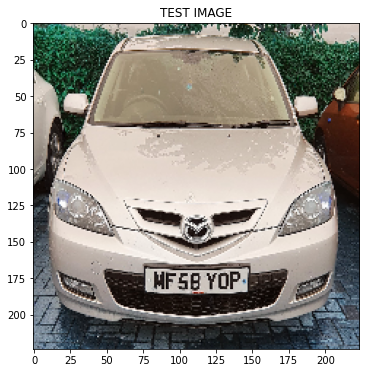

In [ ]:
import cv2
test_img_path = '/content/drive/MyDrive/test_1.jpg'
 
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255
 
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

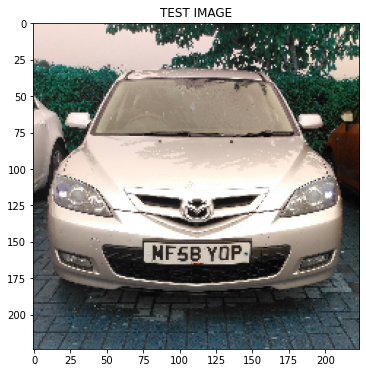

In [ ]:
test_img_path = '/content/drive/MyDrive/c1.jpg'
 
img = cv2.imread(test_img_path)
resized_img1 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255
 
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img1[0])

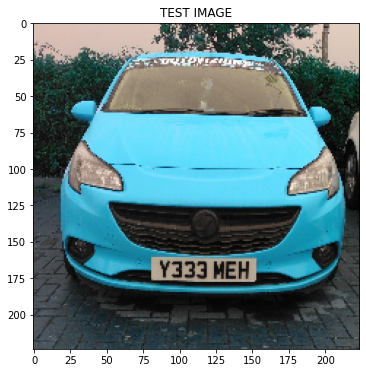

In [ ]:
test_img_path = '/content/drive/MyDrive/c6.jpg'
 
img = cv2.imread(test_img_path)
resized_img2 = cv2.resize(img, (224, 224)).reshape(-1, 224, 224, 3)/255
 
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img2[0])

In [ ]:
ans = model.predict(resized_img)
# ans = mod.predict(img)
ans1 = model.predict(resized_img1)
ans2 = model.predict(resized_img2)

In [ ]:
mod = tf.keras.models.load_model('test.h5')

In [ ]:
output = tf.nn.softmax(ans[0])
print(classes)
print(np.argmax(output))

dict_keys(['Audi', 'BMW', 'Citroen', 'Mazda', 'Peugeot', 'VW'])
3


In [ ]:
print(output)

tf.Tensor([0.12957112 0.12957372 0.12957232 0.12959252 0.12958333 0.352107  ], shape=(6,), dtype=float32)


In [ ]:
print(ans[0])

In [ ]:
output1 = tf.nn.softmax(ans1[0])
print(classes)
print(np.argmax(output1))

dict_keys(['Audi', 'BMW', 'Citroen', 'Mazda', 'Peugeot', 'VW'])
5


In [ ]:
output2 = tf.nn.softmax(ans2[0])
print(classes)
print(np.argmax(output2))

dict_keys(['Audi', 'BMW', 'Citroen', 'Mazda', 'Peugeot', 'VW'])
4


In [ ]:
model.save('test.h5')